In [1]:
%matplotlib inline

import os
from matplotlib_inline import backend_inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
import scipy.io
from datetime import datetime
import pywt

backend_inline.set_matplotlib_formats('svg')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
plt.rcParams['font.sans-serif'] = ['SimHei']

In [2]:
# convert str to datatime
# 将字符串转换为时间
def convert_to_time(hmm):
    year, month, day, hour, minute, second = int(hmm[0]), int(hmm[1]), int(hmm[2]), int(hmm[3]), int(hmm[4]), int(hmm[5])
    return datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)


# load .mat data
# 加载.mat格式的数据
def loadMat(matfile):
    data_mat = scipy.io.loadmat(matfile)
    filename = matfile.split("/")[-1].split(".")[0]
    col = data_mat[filename]
    col = col[0][0][0][0]
    size = col.shape[0]

    data_mat = []
    for i in range(size):
        k = list(col[i][3][0].dtype.fields.keys())
        d1, d2 = {}, {}
        if str(col[i][0][0]) != 'impedance':
            for j in range(len(k)):
                t = col[i][3][0][0][j][0];
                l = [t[m] for m in range(len(t))]
                d2[k[j]] = l
        d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2
        data_mat.append(d1)

    return data_mat

# get capacity data
# 得到电池容量的数据
def getBatteryCapacity(Battery):
    cycle, capacity = [], []
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            capacity.append(Bat['data']['Capacity'][0])
            cycle.append(i)
            i += 1
    return [cycle, capacity]

Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
dir_path = './dataset/'

Battery = {}
for name in Battery_list:
    print('Load Dataset ' + name + '.mat ...')
    path = dir_path + name + '.mat'
    data_mat = loadMat(path)
    Battery[name] = getBatteryCapacity(data_mat)


len(Battery['B0005'][0]), len(Battery['B0005'][1])

Load Dataset B0005.mat ...


C:\Users\Coyle\AppData\Local\Temp\ipykernel_15824\126766349.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2


Load Dataset B0006.mat ...
Load Dataset B0007.mat ...
Load Dataset B0018.mat ...


(168, 168)

### 移动平均滤波

Text(0, 0.5, 'Capacity')

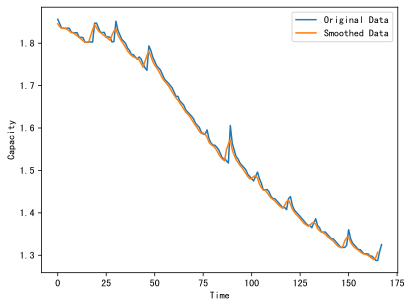

In [3]:
# 原始的锂电池容量衰退数据
original_data = Battery['B0005'][1]

# 移动平均滤波函数
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# 使用移动平均进行数据平滑
window_size = 3  # 滑动窗口大小
smoothed_data = moving_average(original_data, window_size)

# 可视化原始数据和平滑后的数据
plt.plot(original_data, label='Original Data')
plt.plot(smoothed_data, label='Smoothed Data')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Capacity')

### 傅立叶变换

Text(0, 0.5, 'Capacity')

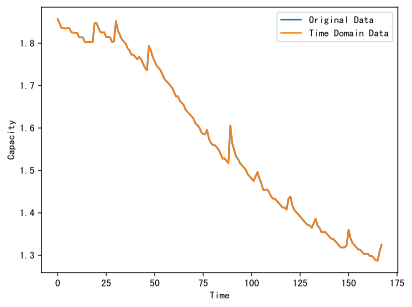

In [4]:
# 原始的锂电池容量衰退数据
original_data = Battery['B0005'][1]

# 傅立叶变换
fft_data = fft(original_data)

# 反傅立叶变换
ifft_data = ifft(fft_data)

# 可视化原始数据和反傅立叶变换后的数据
plt.plot(original_data, label='Original Data')
plt.plot(ifft_data.real, label='Time Domain Data')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Capacity')

### 小波平滑（Wavelet Smoothing）

Text(0, 0.5, 'Capacity')

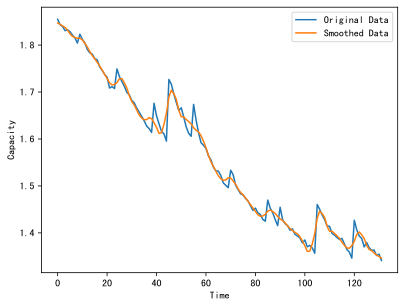

In [5]:
# 原始的时间序列数据
original_data = Battery['B0018'][1]

# 小波平滑函数
def wavelet_smoothing(data, wavelet='db4', level=2):
    # 小波分解
    coeffs = pywt.wavedec(data, wavelet, level=level)
    
    # 阈值处理（可根据需求调整阈值）
    threshold = 2.0
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
    
    # 小波重构
    smoothed_data = pywt.waverec(coeffs, wavelet)
    
    return smoothed_data

# 使用小波平滑
smoothed_data = wavelet_smoothing(original_data)

# 可视化原始数据和平滑后的数据
plt.plot(original_data, label='Original Data')
plt.plot(smoothed_data, label='Smoothed Data')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Capacity')

### Kalman滤波

Text(0, 0.5, 'Capacity')

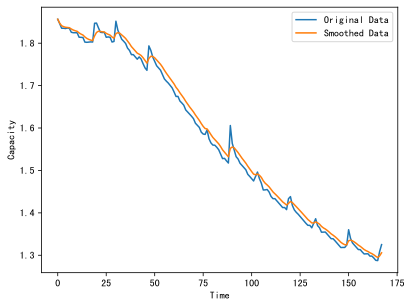

In [6]:
# 原始的时间序列数据
original_data = Battery['B0005'][1]

# Kalman滤波函数
def kalman_filter(data, process_variance, measurement_variance):
    # 初始化滤波器参数
    state = data[0]  # 初始状态
    state_estimate = state
    estimate_error = 1.0
    
    # 存储平滑后的数据
    smoothed_data = [state]
    
    for measurement in data[1:]:
        # 预测步骤
        prediction = state_estimate
        prediction_error = estimate_error + process_variance
        
        # 更新步骤
        kalman_gain = prediction_error / (prediction_error + measurement_variance)
        state_estimate = prediction + kalman_gain * (measurement - prediction)
        estimate_error = (1 - kalman_gain) * prediction_error
        
        # 存储平滑后的数据
        smoothed_data.append(state_estimate)
        state = state_estimate
    
    return np.array(smoothed_data)

# 使用Kalman滤波
process_variance = 0.01  # 系统噪音方差
measurement_variance = 0.1  # 观测噪音方差
smoothed_data = kalman_filter(original_data, process_variance, measurement_variance)

# 可视化原始数据和平滑后的数据
plt.plot(original_data, label='Original Data')
plt.plot(smoothed_data, label='Smoothed Data')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Capacity')

### 测试利用小波分解增加浮点数据维度

168
4
41
41
59
95


D:\programs\miniconda3\envs\torch-gpu\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 3 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Text(0, 0.5, 'Capacity')

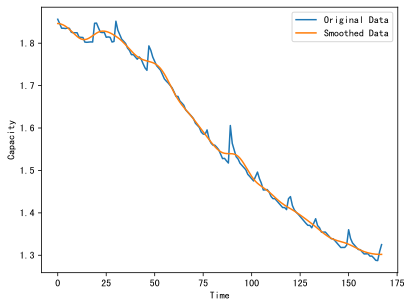

In [20]:
# 原始的时间序列数据
original_data = Battery['B0005'][1]
print(len(original_data))

# 小波平滑函数
def wavelet_smoothing(data, wavelet='db12', level=3):
    # 小波分解
    coeffs = pywt.wavedec(data, wavelet, level=level)
    print(len(coeffs))
    print(len(coeffs[0]))
    print(len(coeffs[1]))
    print(len(coeffs[2]))
    print(len(coeffs[3]))
    
    # 阈值处理（可根据需求调整阈值）
    threshold = 2.0
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
    
    # 小波重构
    smoothed_data = pywt.waverec(coeffs, wavelet)
    
    return smoothed_data

# 使用小波平滑
smoothed_data = wavelet_smoothing(original_data)

# 可视化原始数据和平滑后的数据
plt.plot(original_data, label='Original Data')
plt.plot(smoothed_data, label='Smoothed Data')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Capacity')